In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set()

from sklearn.svm import SVC
from sklearn import svm, datasets
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

parameters = {}
KERNEL_LINEAR = 1
KERNEL_RBF = 2

DATASET_LINEARLY_SEPARABLE = 1
DATASET_CIRCULAR = 2

In [2]:
def get_data():
    data = np.loadtxt("iris.txt")
    iris_data = data[50:]
    return iris_data 

def get_train_and_test(feature):
    iris_data = get_data()

    positive_data = iris_data[:50, feature]
    positive_data = np.expand_dims(positive_data, axis=2)

    negative_data = iris_data[50:, feature]
    negative_data = np.expand_dims(negative_data, axis=2)

    train_data_positive = positive_data[:25]
    train_data_negative = negative_data[:25]

    test_data_positive = positive_data[25:]
    test_data_negative = negative_data[25:]

    train_data = np.concatenate((train_data_positive, train_data_negative), axis=0)
    test_data = np.concatenate((test_data_positive, test_data_negative), axis=0)

    train_label = [1.0] * len(train_data_positive) + [-1.0] * len(train_data_negative)
    test_label = [1.0] * len(test_data_positive) + [-1.0] * len(test_data_negative)

    train_label_plot = ['positive'] * len(train_data_positive) + ['negative'] * len(train_data_negative)
    test_label_plot = ['positive'] * len(test_data_positive) + ['negative'] * len(test_data_negative)

    return(train_data, test_data, train_label, test_label, train_label_plot, test_label_plot, train_data_positive, train_data_negative, test_data_positive, test_data_negative)

In [3]:
def generate_data(dataset):
    feature = [2, 3]

    train_data, test_data, train_label, test_label, train_label_plot, test_label_plot, train_data_positive, train_data_negative, test_data_positive, test_data_negative = get_train_and_test(feature)

    train_data = np.squeeze(train_data, axis=(2,))
    train_label = np.array(train_label)

    X = train_data
    y = train_label 
    
    return X, y

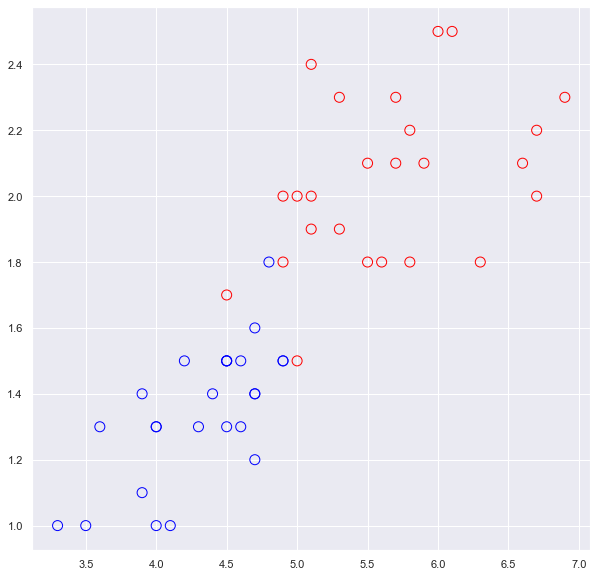

In [4]:
X, y = generate_data(DATASET_LINEARLY_SEPARABLE)
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(X[:,0], X[:,1], edgecolors=['red' if y_i == -1 else 'blue' for y_i in y], facecolors='none', s=100)
plt.show()

In [5]:
def gram_matrix(X, Y, kernel_type, gamma=0.5):
    K = np.zeros((X.shape[0], Y.shape[0]))
    
    if kernel_type == KERNEL_LINEAR:
        for i, x in enumerate(X):
            for j, y in enumerate(Y):
                K[i, j] = np.dot(x.T, y)
                
    elif kernel_type == KERNEL_RBF:
        for i, x in enumerate(X):
            for j, y in enumerate(Y):
                K[i, j] = np.exp(-gamma * np.linalg.norm(x - y) ** 2)
        
    return K

In [6]:
def train_svm(kernel):
    C = 10

    feature = [2, 3]
    train_data, test_data, train_label, test_label, train_label_plot, test_label_plot, train_data_positive, train_data_negative, test_data_positive, test_data_negative = get_train_and_test(feature)

    train_data = np.squeeze(train_data, axis=(2,))
    train_label = np.array(train_label)

    n, k = train_data.shape
    
    y_matrix = y.reshape(1, -1)
    H = np.dot(y_matrix.T, y_matrix) * gram_matrix(X, X, kernel)
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((n, 1)))
    G = cvxopt_matrix(np.vstack((-np.eye((n)), np.eye(n))))
    h = cvxopt_matrix(np.vstack((np.zeros((n,1)), np.ones((n,1)) * C)))
    A = cvxopt_matrix(y_matrix)
    b = cvxopt_matrix(np.zeros(1))
    
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10

    return cvxopt_solvers.qp(P, q, G, h, A, b)

In [7]:
X, y = generate_data(DATASET_LINEARLY_SEPARABLE)
# X = parameters['X']
svm_parameters = train_svm(KERNEL_LINEAR)
print(svm_parameters)

pcost       dcost       gap    pres   dres
 0: -2.3310e+01 -2.9472e+03  6e+03  6e-01  2e-13
 1:  3.2470e+01 -7.2125e+02  1e+03  5e-02  2e-13
 2: -2.1288e+01 -1.6603e+02  2e+02  6e-03  1e-13
 3: -4.9203e+01 -9.4768e+01  5e+01  2e-03  2e-13
 4: -5.8984e+01 -7.2923e+01  1e+01  2e-04  2e-13
 5: -6.2339e+01 -7.0672e+01  8e+00  1e-04  2e-13
 6: -6.5178e+01 -6.6910e+01  2e+00  2e-05  2e-13
 7: -6.5868e+01 -6.5934e+01  7e-02  3e-08  2e-13
 8: -6.5900e+01 -6.5900e+01  7e-04  3e-10  2e-13
 9: -6.5900e+01 -6.5900e+01  7e-06  3e-12  1e-13
10: -6.5900e+01 -6.5900e+01  7e-08  3e-14  2e-13
11: -6.5900e+01 -6.5900e+01  7e-10  1e-14  2e-13
Optimal solution found.
{'x': <50x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <100x1 matrix, tc='d'>, 'z': <100x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 6.722454823557572e-10, 'relative gap': 1.020099366250506e-11, 'primal objective': -65.89999999967392, 'dual objective': -65.90000000034583, 'primal infeasibility': 1.0658141036401503e-14, 'dual infeasibi

In [14]:
def get_parameters(alphas):
    threshold = 1e-5 # Values greater than zero (some floating point tolerance)
    S = (alphas > threshold).reshape(-1, )
    w = np.dot(X.T, alphas * y)
    b = y[S] - np.dot(X[S], w) # b calculation
    b = np.mean(b)
    return w, b, S

alphas = np.array(svm_parameters['x'])[:, 0]
w, b, S = get_parameters(alphas)

print('Alphas:', alphas[S][0:50])
print('w and b', w, b)

Alphas: [ 9.00006523 10.         10.          8.99993477  8.         10.
 10.         10.        ]
w and b [-1.6 -4.2] 14.74250000013928


In [12]:
# alphas
for i in range(len(alphas)):
    print('{}'.format(round(alphas[i], 4)))

0.0
0.0
9.0001
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
8.9999
0.0
0.0
0.0
8.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
10.0
0.0


In [15]:
S

array([False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True, False, False, False,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False])

In [10]:
1e-5

1e-05